# Simpsons Paradox

http://causality.cs.ucla.edu/blog/index.php/2020/07/06/race-covid-mortality-and-simpsons-paradox-by-dana-mackenzie/



In [8]:
import sys
sys.path.insert(0, '../src/data')
import bame_datastore
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from altair import *

In [2]:
url = "https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fcountsandratiosofcoronavirusrelateddeathsbyethnicgroupenglandandwales%2f2march2020to10april2020/reft1countsratiocovidsexageeth06052020185223.xlsx"
r = requests.get(url)
fpath = f"../data/external/deaths_ethnicities.xlsx"
with open(fpath, 'wb') as outfile:
    outfile.write(r.content)
df_raw = pd.read_excel(fpath, sheet_name="Table 1", skiprows=2, usecols=[0,1,2,3], nrows= 28)
df = df_raw.set_index(["Ethnicity", "Ageband"]).groupby(by = ["Ethnicity", "Ageband"]).sum()
df

Counts of Coronavirus-related deaths
Ethnicity                    Ageband                                      
Bangladeshis/Pakistani       0-64                                      100
                             65+                                       286
Black                        0-64                                      185
                             65+                                       581
Chinese                      0-64                                       10
                             65+                                        49
Indian                       0-64                                       82
                             65+                                       401
Mixed/Multiple Ethnic Groups 0-64                                       18
                             65+                                        76
Other Ethnic Group           0-64                                       65
                             65+                                       226
White                        0-64                                     1036
                             65+                                      9690

In [54]:
df_grouped = df.groupby("Ethnicity").sum()
total_deaths = df_grouped.sum()[0]
df_grouped["pct_deaths"] = (df_grouped["Counts of Coronavirus-related deaths"]/total_deaths)*100
df_grouped.columns = ["count_deaths", "pct_deaths"]
df_grouped

,count_deaths,pct_deaths
Ethnicity,,
Bangladeshis/Pakistani,386,3.014447
Black,766,5.982038
Chinese,59,0.460758
Indian,483,3.771964
Mixed/Multiple Ethnic Groups,94,0.734088
Other Ethnic Group,291,2.272550
White,10726,83.764155


In [76]:
df_age_raw = df.groupby(by = ["Ethnicity", "Ageband"]).sum().reset_index()
df_age_raw = df_age_raw.pivot(index = "Ethnicity", columns="Ageband")
df_age_raw.columns = ["count_064", "count_64+"]
df_age = df_age_raw.copy()
df_age["pct_064"] = (df_age["count_064"]/total_deaths)*100
df_age["pct_64+"] = (df_age["count_64+"]/total_deaths)*100
df_age = df_age[["count_064", "pct_064", "count_64+", "pct_64+"]]
df_age

,count_064,pct_064,count_64+,pct_64+
Ethnicity,,,,
Bangladeshis/Pakistani,100,0.780945,286,2.233503
Black,185,1.444748,581,4.537290
Chinese,10,0.078094,49,0.382663
Indian,82,0.640375,401,3.131589
Mixed/Multiple Ethnic Groups,18,0.140570,76,0.593518
Other Ethnic Group,65,0.507614,226,1.764936
White,1036,8.090590,9690,75.673565


In [85]:
under_64_tot  = df_age_raw.count_064.sum()
over_64_tot  = df_age_raw["count_64+"].sum()
df_age_alt = df_age_raw.copy()
df_age_alt["pct_064_alt"] = (df_age_alt["count_064"]/under_64_tot)*100
df_age_alt["pct_64+_alt"] = (df_age_alt["count_64+"]/over_64_tot)*100
df_age_alt = df_age_alt[["count_064", "pct_064_alt", "count_64+", "pct_64+_alt"]]
df_age_alt

,count_064,pct_064_alt,count_64+,pct_64+_alt
Ethnicity,,,,
Bangladeshis/Pakistani,100,6.684492,286,2.528959
Black,185,12.366310,581,5.137501
Chinese,10,0.668449,49,0.433283
Indian,82,5.481283,401,3.545848
Mixed/Multiple Ethnic Groups,18,1.203209,76,0.672031
Other Ethnic Group,65,4.344920,226,1.998408
White,1036,69.251337,9690,85.683969


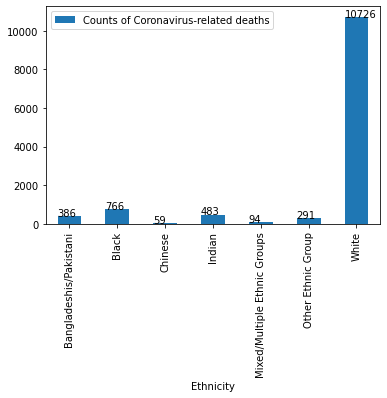

In [4]:
ax = df.groupby(by = ["Ethnicity"]).sum().plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))




Counts of Coronavirus-related deaths      
Ageband                                                      0-64   65+
Ethnicity                                                              
Bangladeshis/Pakistani                                        100   286
Black                                                         185   581
Chinese                                                        10    49
Indian                                                         82   401
Mixed/Multiple Ethnic Groups                                   18    76
Other Ethnic Group                                             65   226
White                                                        1036  9690

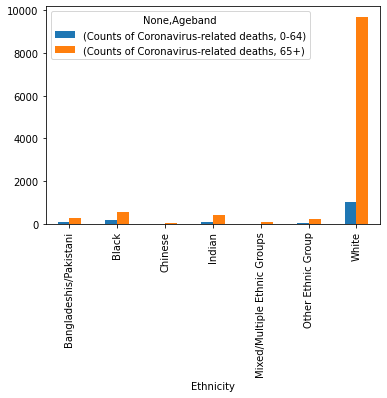

In [5]:
df_alt = df.groupby(by = ["Ethnicity", "Ageband"]).sum().reset_index()
df_alt = df_alt.pivot(index = "Ethnicity", columns="Ageband")
df_alt.plot.bar()
df_alt

In [6]:
df_alt["total"] = df_alt[df_alt.columns[0]] + df_alt[df_alt.columns[1]]
df_alt[df_alt.columns[0]] = (df_alt[df_alt.columns[0]]/df_alt["total"])*100
df_alt[df_alt.columns[1]] = (df_alt[df_alt.columns[1]]/df_alt["total"])*100
df_alt

Counts of Coronavirus-related deaths             \
Ageband                                                      0-64        65+   
Ethnicity                                                                      
Bangladeshis/Pakistani                                  25.906736  74.093264   
Black                                                   24.151436  75.848564   
Chinese                                                 16.949153  83.050847   
Indian                                                  16.977226  83.022774   
Mixed/Multiple Ethnic Groups                            19.148936  80.851064   
Other Ethnic Group                                      22.336770  77.663230   
White                                                    9.658773  90.341227   

                              total  
Ageband                              
Ethnicity                            
Bangladeshis/Pakistani          386  
Black                           766  
Chinese                          59  
Indian                          483  
Mixed/Multiple Ethnic Groups     94  
Other Ethnic Group              291  
White                         10726

In [9]:
df_alt_sum = df.groupby(by = ["Ethnicity", "Ageband"]).sum().reset_index()
df_alt_sum = df_alt_sum.pivot(index = "Ethnicity", columns="Ageband").reset_index()
df_alt_sum["dummy"] = np.where(df_alt_sum['Ethnicity']=='White', "White", "Other")
df_alt_sum = df_alt_sum.groupby("dummy").sum()
df_alt_sum
df_alt_sum["total"] = df_alt_sum[df_alt_sum.columns[0]] + df_alt_sum[df_alt_sum.columns[1]]
df_alt_sum[df_alt_sum.columns[0]] = (df_alt_sum[df_alt_sum.columns[0]]/df_alt_sum["total"])*100
df_alt_sum[df_alt_sum.columns[1]] = (df_alt_sum[df_alt_sum.columns[1]]/df_alt_sum["total"])*100
df_alt_sum

/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Counts of Coronavirus-related deaths             total
Ageband                                 0-64        65+       
dummy                                                         
Other                              22.126022  77.873978   2079
White                               9.658773  90.341227  10726

In [10]:
2079/(10726+2079)

0.16235845372901211

# Population Estimates

In [11]:
pop_df = bame_datastore.pop_est.df.copy() # import 2020 population estimates
cols_to_sum = pop_df.columns[68:] # gather 65+ columns
# pop_df['total_65+'] = pop_df[cols_to_sum].sum(axis=1)  # create 65+ column
# pop_df["pct_65+"] = pop_df["total_65+"]/ pop_df["All ages"]
eng_wal_df = pop_df.loc[pop_df['Name'] == "ENGLAND AND WALES"]
eng_wal_df.drop(columns=["Geography1", "All ages"])

,Name,0,1,2,3,4,5,6,7,8,...,81,82,83,84,85,86,87,88,89,90+
Code,,,,,,,,,,,,,,,,,,,,,
K04000001,ENGLAND AND WALES,649388.0,676412.0,698837.0,720721.0,719821.0,726317.0,742744.0,765225.0,750173.0,...,332255.0,306983.0,282197.0,257792.0,228197.0,206177.0,188071.0,167219.0,143992.0,547789.0


# Alt Ethnicity Data

Where is this 14% stat coming from? - 2011 census shows 10%


Maybe need to use more up to date ethnicitiy data 
https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationcharacteristicsresearchtables

In [12]:
ethnic_df = bame_datastore.ethnicity_data.df
eth_total_df = ethnic_df.drop(columns=["Geography_name", "Denominator"]).sum()
# (1 - (eth_total_df[18:].sum()/eth_total_df.sum()))*100

ethnic_df

,Geography_name,Denominator,Arab,Asian,Asian Other,Bangladeshi,Black,Black African,Black Caribbean,Black Other,...,Mixed White and Black African,Mixed White and Black Caribbean,Other,Other ethnic group,Pakistani,White,White British,White Gypsy or Irish Traveller,White Irish,White Other
Geography_code,,,,,,,,,,,,,,,,,,,,,
E06000001,Hartlepool,92028,0.06,1.42,0.33,0.23,0.18,0.14,0.04,0.01,...,0.06,0.20,0.11,0.05,0.32,97.69,96.63,0.04,0.21,0.81
E06000002,Middlesbrough,138412,0.69,7.78,0.96,0.18,1.25,1.06,0.07,0.12,...,0.33,0.39,1.08,0.39,4.92,88.18,86.05,0.06,0.41,1.65
E06000003,Redcar and Cleveland,135177,0.03,0.64,0.17,0.07,0.09,0.06,0.03,0.01,...,0.08,0.22,0.10,0.07,0.22,98.54,97.60,0.06,0.31,0.57
E06000004,Stockton-on-Tees,191610,0.12,3.46,0.56,0.07,0.59,0.49,0.04,0.06,...,0.16,0.22,0.29,0.16,1.60,94.62,93.40,0.07,0.28,0.86
E06000005,Darlington,105564,0.11,2.09,0.44,0.50,0.34,0.20,0.10,0.04,...,0.09,0.44,0.25,0.14,0.14,96.24,93.69,0.33,0.31,1.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W06000020,Torfaen,91075,0.02,1.07,0.50,0.09,0.19,0.05,0.10,0.04,...,0.11,0.26,0.10,0.09,0.07,97.98,96.85,0.17,0.34,0.61
W06000021,Monmouthshire,91323,0.08,0.99,0.40,0.04,0.16,0.09,0.05,0.02,...,0.06,0.19,0.14,0.07,0.06,98.03,96.10,0.01,0.43,1.49
W06000022,Newport,145736,0.64,5.48,0.89,1.20,1.74,1.03,0.54,0.17,...,0.25,0.90,0.99,0.35,2.15,89.91,86.98,0.06,0.53,2.34


# Ethnicity Data
2011 census data https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/population-of-england-and-wales/latest#by-ethnicity

Make it compatible with Morbidity data

In [33]:
group_eth_dict = {'Bangladeshi': "Bangladeshis/Pakistani",
                 'Chinese': "Chinese",
                 'Indian': "Indian",
                 'Pakistani': "Bangladeshis/Pakistani",
                 'Asian other': "Other Ethnic Group",
                 'Black': "Black",
                 'Mixed':"Mixed/Multiple Ethnic Groups",
                 'White':"White",
                 'Other':"Other Ethnic Group"}



In [35]:
url = "https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/population-of-england-and-wales/latest/downloads/by-ethnicity.csv"
eth_df_raw = pd.read_csv(url, thousands=',')

eth_df = eth_df_raw.copy()
eth_df["eth_grouped"] = eth_df["Ethnicity"].map(group_eth_dict)
eth_df = eth_df.dropna().groupby("eth_grouped").sum()

total_check = eth_df.Number.sum() == eth_df_raw.loc[eth_df_raw.Ethnicity=="All"].Number #check sum up
pct_check = eth_df_raw.loc[eth_df_raw.Ethnicity=="All"]["%"]==100
print(total_check, pct_check)
eth_df.columns = ["count_people", "pct_people"]



0    True
Name: Number, dtype: bool 0    True
Name: %, dtype: bool


In [95]:
plot_df

,count_people,pct_people,count_deaths,pct_deaths,count_064,pct_064,count_64+,pct_64+
eth_grouped,,,,,,,,
Bangladeshis/Pakistani,1571712,2.8,386,3.014447,100,0.780945,286,2.233503
Black,1864890,3.3,766,5.982038,185,1.444748,581,4.537290
Chinese,393141,0.7,59,0.460758,10,0.078094,49,0.382663
Indian,1412958,2.5,483,3.771964,82,0.640375,401,3.131589
Mixed/Multiple Ethnic Groups,1224400,2.2,94,0.734088,18,0.140570,76,0.593518
Other Ethnic Group,1399416,2.5,291,2.272550,65,0.507614,226,1.764936
White,48209395,86.0,10726,83.764155,1036,8.090590,9690,75.673565


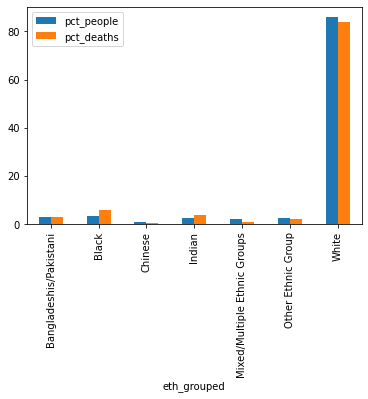

In [94]:
plot_df = eth_df.join(df_grouped).join(df_age)

plot_df.drop(columns = ["count_people", "count_deaths", "count_064", "count_64+",
                       "pct_064", "pct_64+"]).plot(kind='bar')

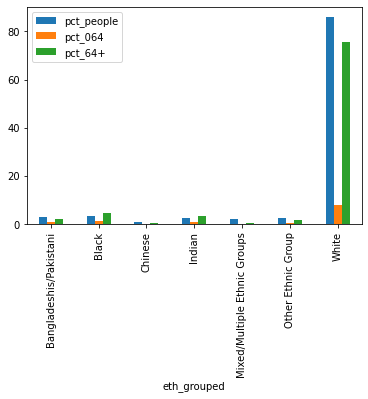

In [86]:
plot_df.drop(columns = ["count_people", "count_deaths", "count_064", "count_64+",
                       "pct_deaths"]).plot(kind='bar')

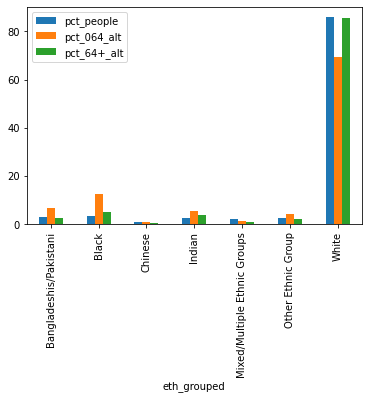

In [92]:
df_age_alt
plot_df = eth_df.join(df_grouped).join(df_age_alt)

plot_df.drop(columns = ["count_people", "count_deaths", "count_064", "count_64+",
                       "pct_deaths"]).plot(kind='bar')